The goal of this notebooks is to test the performance of several models. 
I will use bag-of-words as a baseline. 
Then I will use Keras' Embedding Layer, GloVe as a pre-trained model, an LSTM and a 1D ConvNet.

Performance metrics are accuracy, precision and recall.

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys
import tensorflow as tf

from collections import Counter
from imblearn.over_sampling import SMOTE
from keras import layers
from keras import models
from keras import utils
from keras.utils import to_categorical
from tensorflow import keras

%matplotlib inline

# Preparation Steps

In [2]:
# folders
home = os.getenv("HOME")
nlp_repo = os.path.join(home, 'git/nlp-product-sentiment-classification')

# data
train_csv_path = os.path.join(nlp_repo, 'data/03_processed/Train.csv')
train_descr = pd.read_csv(train_csv_path)

test_csv_path = os.path.join(nlp_repo, 'data/03_processed/Test.csv')
test_descr = pd.read_csv(test_csv_path)

# encoded tokens
preprocessed_corpus_path_TF = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed_TF.p')

preprocessed_corpus_path_TF_oh = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed_TF_oh.p')

In [3]:
# read-in the list of tokens and the vocabulary
sequences, word_index = pd.read_pickle(preprocessed_corpus_path_TF)

# Parameters

In [4]:
# Embedding Tokens

# max_words = vocabulary size = our samples - number of most frequent words.
# I set it to 10.000, although in this case there are less.
# I do this to parametise the code.
# Aleternatively, I can set it to the length of our vocabulary = word_index
max_words = 10000

# embedding_size = embedding dimensionality
embedding_size = 10

# max_len = sequence length - the text is cut off after this number of words
# in this case I define it as the maximum sequence length in our list of tokenised sequences
max_len = np.max([len(x) for x in sequences])


# Training parameters
model_path = "product_descr_TF.h5"
epochs = 15
batch_size = 28

# For GloVe word-embeddings matrix (pre-trained model)
embedding_dim = 100

In [5]:
data = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=max_len)

In [6]:
labels = train_descr.loc[:, 'Sentiment'].to_list()

In [7]:
data.shape

(6364, 33)

### Oversampling the Minortiy Classes

In [8]:
def oversample_smote(data, labels):
    oversample = SMOTE()
    data, labels =  oversample.fit_resample(data, labels)
    
    counter = Counter(labels)
    for k,v in counter.items():
        per = v / len(labels) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    # plot the distribution
    plt.bar(counter.keys(), counter.values())
    plt.show()
    
    return data, labels

Class=2, n=3765 (25.000%)
Class=1, n=3765 (25.000%)
Class=3, n=3765 (25.000%)
Class=0, n=3765 (25.000%)


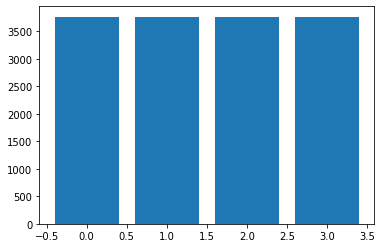

In [9]:
data_ovs, labels_ovs = oversample_smote(data, labels)

In [10]:
dimensions_labels = len(np.unique(labels_ovs))

In [11]:
labels_encoded = tf.one_hot(indices=labels_ovs, depth=dimensions_labels)

In [12]:
labels_encoded = np.asarray(labels_encoded)

In [24]:
print('Shape of data_ovs tensor:', data_ovs.shape)
print('Shape of label_ovs tensor', labels_encoded.shape)

Shape of data_ovs tensor: (15060, 33)
Shape of label_ovs tensor (15060, 4)


In [14]:
indices = np.arange(data_ovs.shape[0])
np.random.shuffle(indices)

In [15]:
data_ovs = data_ovs[indices]
labels_encoded = labels_encoded[indices]

In [16]:
training_samples = int(0.8 * len(data_ovs))

In [17]:
x_train = data_ovs[:training_samples]
y_train = labels_encoded[:training_samples]

x_val = data_ovs[training_samples:]
y_val = labels_encoded[training_samples:]

In [18]:
def get_key(my_dict, val):
    for key, value in my_dict.items():
        if val == value:
            return key

    return "key doesn't exist"

In [19]:
get_key(word_index, 2)

'sxsw'

# Bag-of-Words

* Bag-of-words will be used as a baseline model. 
* Its advantages are that it is fairly easy and quick to build. 
* The downside is that bag-of-words does not perserve the order of the sentence. As a result the structure of a sentence is lost. 
* RNNs & 1D ConvNets will be tried later in order to remedy this.

In [20]:
sequences_oh, word_index_oh = pd.read_pickle(preprocessed_corpus_path_TF_oh)

In [21]:
sequences_oh.shape

(6364, 10000)

Class=2, n=3765 (25.000%)
Class=1, n=3765 (25.000%)
Class=3, n=3765 (25.000%)
Class=0, n=3765 (25.000%)


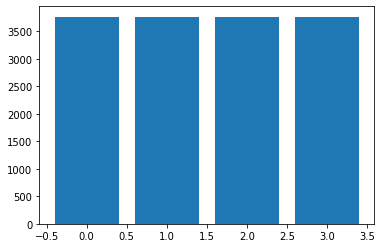

In [22]:
sequences_oh, labels_oh = oversample_smote(sequences_oh, labels)

In [23]:
sequences_oh.shape

(15060, 10000)

In [25]:
labels_encoded_oh = tf.one_hot(indices=labels_oh, depth=dimensions_labels)

In [26]:
data_oh = sequences_oh[indices]

In [27]:
training_samples_oh = int(0.8 * len(data_oh))

In [28]:
x_train_oh = data_oh[:training_samples_oh]
y_train_oh = labels_encoded_oh[:training_samples_oh]

x_val_oh = data_oh[training_samples_oh:]
y_val_oh = labels_encoded_oh[training_samples_oh:]

In [29]:
metrics = [
    keras.metrics.CategoricalAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')]

# Fully Connected NN & Bag-of-Words

In [30]:
model_bow = models.Sequential()

model_bow.add(layers.Dense(16, activation='relu',
                           input_shape=(max_words, )))
# model_bow.add(layers.Dropout(0.75))
model_bow.add(layers.Dense(16, activation='relu'))
# model_bow.add(layers.Dropout(0.75))
model_bow.add(layers.Dense(dimensions_labels, activation='softmax'))

model_bow.summary()

model_bow.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 160,356
Trainable params: 160,356
Non-trainable params: 0
_________________________________________________________________


In [31]:
history_bow = model_bow.fit(
    x_train_oh, y_train_oh,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val_oh, y_val_oh)
)

Epoch 1/15
431/431 [==============================] - 1s 3ms/step - loss: 1.3582 - accuracy: 0.3107 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.6980 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
431/431 [==============================] - 1s 2ms/step - loss: 1.3299 - accuracy: 0.3518 - precision: 0.4490 - recall: 0.0018 - val_loss: 1.7347 - val_accuracy: 0.0023 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
431/431 [==============================] - 1s 2ms/step - loss: 1.2729 - accuracy: 0.4024 - precision: 0.6138 - recall: 0.0459 - val_loss: 1.7992 - val_accuracy: 0.0558 - val_precision: 0.0195 - val_recall: 0.0020
Epoch 4/15
431/431 [==============================] - 1s 2ms/step - loss: 1.1847 - accuracy: 0.4625 - precision: 0.6758 - recall: 0.1702 - val_loss: 1.9811 - val_accuracy: 0.0833 - val_precision: 0.0710 - val_recall: 0.0183
Epoch 5/15
431/431 [==============================] - 1s 2ms/step - loss: 1.

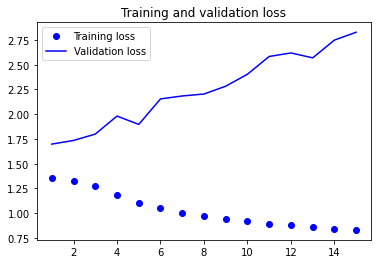

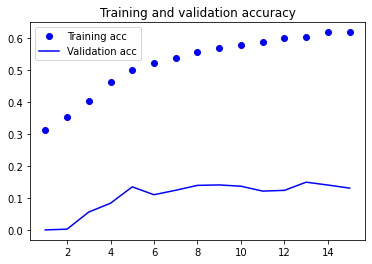

In [32]:
loss_bow = history_bow.history['loss']
val_loss_bow = history_bow.history['val_loss']
acc_bow = history_bow.history['accuracy']
val_acc_bow = history_bow.history['val_accuracy']


epochs_graph = range(1, len(acc_bow) + 1)

plt.plot(epochs_graph, loss_bow, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_bow, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_bow, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_bow, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# Fully Conneceted NN & Embeddings Layer

In [33]:
model_emb = models.Sequential()

model_emb.add(layers.Embedding(max_words+1,
                               embedding_size, input_length=max_len))
model_emb.add(layers.Flatten())
model_emb.add(layers.Dense(32, activation='relu'))
# model_emb.add(layers.Dropout(0.75))
model_emb.add(layers.Dense(32, activation='relu'))
# model_emb.add(layers.Dropout(0.75))
model_emb.add(layers.Dense(dimensions_labels, activation='softmax'))

model_emb.summary()

model_emb.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 10)            100010    
_________________________________________________________________
flatten (Flatten)            (None, 330)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                10592     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 132       
Total params: 111,790
Trainable params: 111,790
Non-trainable params: 0
_________________________________________________________________


In [34]:
history_emb = model_emb.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/15
431/431 [==============================] - 2s 4ms/step - loss: 1.2438 - accuracy: 0.3382 - precision: 0.3585 - recall: 0.0756 - val_loss: 1.1327 - val_accuracy: 0.4758 - val_precision: 0.6134 - val_recall: 0.1939
Epoch 2/15
431/431 [==============================] - 1s 2ms/step - loss: 0.9637 - accuracy: 0.5740 - precision: 0.6673 - recall: 0.3796 - val_loss: 1.1181 - val_accuracy: 0.4957 - val_precision: 0.5755 - val_recall: 0.3529
Epoch 3/15
431/431 [==============================] - 1s 2ms/step - loss: 0.6893 - accuracy: 0.7265 - precision: 0.7741 - recall: 0.6483 - val_loss: 1.2463 - val_accuracy: 0.4851 - val_precision: 0.5313 - val_recall: 0.4173
Epoch 4/15
431/431 [==============================] - 1s 2ms/step - loss: 0.4283 - accuracy: 0.8470 - precision: 0.8702 - recall: 0.8190 - val_loss: 1.5232 - val_accuracy: 0.4874 - val_precision: 0.5002 - val_recall: 0.4499
Epoch 5/15
431/431 [==============================] - 1s 2ms/step - loss: 0.2597 - accuracy: 0.9120 - pr

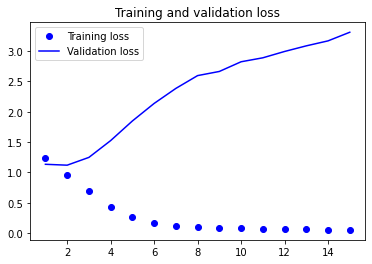

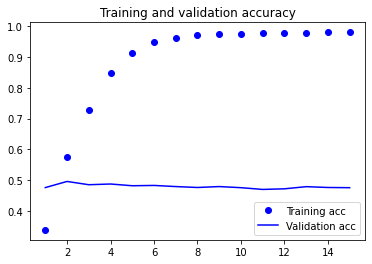

In [35]:
loss_emb = history_emb.history['loss']
val_loss_emb = history_emb.history['val_loss']
acc_emb = history_emb.history['accuracy']
val_acc_emb = history_emb.history['val_accuracy']


epochs_graph = range(1, len(acc_emb) + 1)

plt.plot(epochs_graph, loss_emb, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_emb, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_emb, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_emb, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# Fully Conneceted NN & Pre-Trained Embeddings Layer

In [36]:
glove_dir = './glove.6B'

In [37]:
embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [38]:
embedding_matrix = np.zeros((max_words+1, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(10001, 100)


In [39]:
model_transf = models.Sequential()

model_transf.add(layers.Embedding(max_words+1,
                                  embedding_dim, input_length=max_len))

model_transf.add(layers.Flatten())
model_transf.add(layers.Dense(16, activation='relu'))
# model_transf.add(layers.Dropout(0.75))
model_transf.add(layers.Dense(16, activation='relu'))
# model_transf.add(layers.Dropout(0.75))
model_transf.add(layers.Dense(dimensions_labels, activation='softmax'))

model_transf.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
model_transf.layers[0].trainable = False


# needed in order to save the weights: https://stackoverflow.com/questions/55908188/this-model-has-not-yet-been-built-error-on-model-summary
model_transf.build((max_len,))

model_transf.summary()


model_transf.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 33, 100)           1000100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 3300)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                52816     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 68        
Total params: 1,053,256
Trainable params: 53,156
Non-trainable params: 1,000,100
_________________________________________________________________


In [40]:
history_transf = model_transf.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

model_transf.save_weights(f'{model_path}_transf')

Epoch 1/15
431/431 [==============================] - 1s 3ms/step - loss: 1.2622 - accuracy: 0.4027 - precision: 0.5186 - recall: 0.1620 - val_loss: 1.1786 - val_accuracy: 0.4409 - val_precision: 0.6032 - val_recall: 0.1630
Epoch 2/15
431/431 [==============================] - 1s 2ms/step - loss: 1.1032 - accuracy: 0.4924 - precision: 0.6590 - recall: 0.2365 - val_loss: 1.1427 - val_accuracy: 0.4758 - val_precision: 0.6121 - val_recall: 0.2447
Epoch 3/15
431/431 [==============================] - 1s 2ms/step - loss: 1.0058 - accuracy: 0.5474 - precision: 0.6912 - recall: 0.3295 - val_loss: 1.2093 - val_accuracy: 0.4552 - val_precision: 0.5506 - val_recall: 0.2819
Epoch 4/15
431/431 [==============================] - 1s 2ms/step - loss: 0.9041 - accuracy: 0.6062 - precision: 0.7196 - recall: 0.4347 - val_loss: 1.1699 - val_accuracy: 0.4847 - val_precision: 0.5641 - val_recall: 0.3416
Epoch 5/15
431/431 [==============================] - 1s 2ms/step - loss: 0.8080 - accuracy: 0.6536 - pr

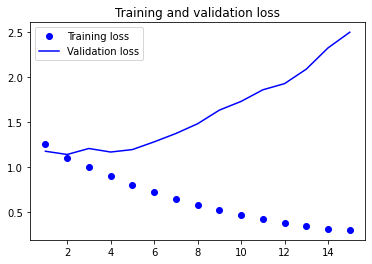

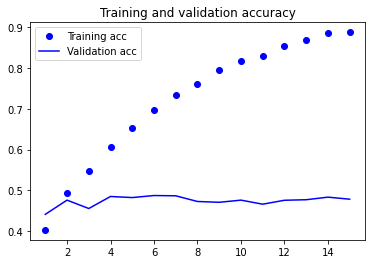

In [41]:
loss_transf = history_transf.history['loss']
val_loss_transf = history_transf.history['val_loss']
acc_transf = history_transf.history['accuracy']
val_acc_transf = history_transf.history['val_accuracy']


epochs_graph = range(1, len(acc_transf) + 1)

plt.plot(epochs_graph, loss_transf, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_transf, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_transf, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_transf, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# LSTM

In [42]:
model_lstm = models.Sequential()

model_lstm.add(layers.Embedding(max_words+1,
                                embedding_dim, input_length=max_len))

# model_lstm.add(layers.Flatten())
# Option 1
model_lstm.add(layers.LSTM(32))

# Option 2
# model.add(layers.LSTM(32, return_sequences=True)) # stacking of LSTMs
# model.add(layers.LSTM(32)) # the size of the hidden state, randomly defined
model_lstm.add(layers.Dense(16, activation='relu'))
# model_lstm.add(layers.Dropout(0.5))
model_lstm.add(layers.Dense(16, activation='relu'))
# model_lstm.add(layers.Dropout(0.5))
model_lstm.add(layers.Dense(dimensions_labels, activation='softmax'))

model_lstm.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
model_lstm.layers[0].trainable = False

model_lstm.summary()

model_lstm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 33, 100)           1000100   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 68        
Total params: 1,017,992
Trainable params: 17,892
Non-trainable params: 1,000,100
_________________________________________________________________


In [43]:
history_lstm = model_lstm.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/15
431/431 [==============================] - 6s 14ms/step - loss: 1.2529 - accuracy: 0.4082 - precision: 0.5315 - recall: 0.1637 - val_loss: 1.2133 - val_accuracy: 0.4150 - val_precision: 0.6481 - val_recall: 0.0734
Epoch 2/15
431/431 [==============================] - 6s 13ms/step - loss: 1.1340 - accuracy: 0.4525 - precision: 0.6178 - recall: 0.1501 - val_loss: 1.1192 - val_accuracy: 0.4751 - val_precision: 0.6243 - val_recall: 0.1550
Epoch 3/15
431/431 [==============================] - 5s 12ms/step - loss: 1.0817 - accuracy: 0.4754 - precision: 0.6239 - recall: 0.1845 - val_loss: 1.0858 - val_accuracy: 0.4807 - val_precision: 0.6307 - val_recall: 0.1826
Epoch 4/15
431/431 [==============================] - 5s 13ms/step - loss: 1.0440 - accuracy: 0.4934 - precision: 0.6322 - recall: 0.2102 - val_loss: 1.0891 - val_accuracy: 0.4638 - val_precision: 0.5681 - val_recall: 0.1633
Epoch 5/15
431/431 [==============================] - 5s 13ms/step - loss: 1.0108 - accuracy: 0.5119

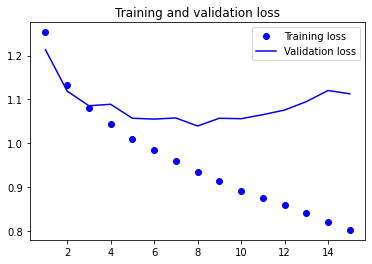

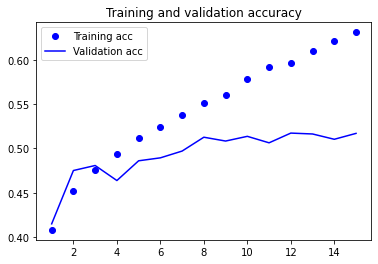

In [44]:
loss_lstm = history_lstm.history['loss']
val_loss_lstm = history_lstm.history['val_loss']
acc_lstm = history_lstm.history['accuracy']
val_acc_lstm = history_lstm.history['val_accuracy']


epochs_graph = range(1, len(acc_lstm) + 1)

plt.plot(epochs_graph, loss_lstm, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_lstm, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_lstm, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_lstm, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# 1D Convolutional NN

In [45]:
model_conv1d = models.Sequential()

model_conv1d.add(layers.Embedding(max_words+1,
                                  embedding_dim, input_length=max_len))

model_conv1d.add(layers.Conv1D(
    32,  # features to be extracted
    5,  # convolutional window size
    activation='relu',
))
# model_conv1d.add(layers.MaxPooling1D(3))
model_conv1d.add(layers.Conv1D(32, 5, activation='relu'))
model_conv1d.add(layers.GlobalMaxPooling1D())
model_conv1d.add(layers.Dense(dimensions_labels, activation='softmax'))

model_conv1d.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
model_conv1d.layers[0].trainable = False

model_conv1d.summary()

model_conv1d.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 33, 100)           1000100   
_________________________________________________________________
conv1d (Conv1D)              (None, 29, 32)            16032     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 32)            5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 132       
Total params: 1,021,416
Trainable params: 21,316
Non-trainable params: 1,000,100
_________________________________________________________________


In [46]:
history_conv1d = model_conv1d.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/15
431/431 [==============================] - 2s 5ms/step - loss: 1.2550 - accuracy: 0.4171 - precision: 0.5765 - recall: 0.1499 - val_loss: 1.1837 - val_accuracy: 0.4363 - val_precision: 0.5923 - val_recall: 0.1577
Epoch 2/15
431/431 [==============================] - 2s 4ms/step - loss: 1.0886 - accuracy: 0.5001 - precision: 0.6367 - recall: 0.2409 - val_loss: 1.1102 - val_accuracy: 0.4771 - val_precision: 0.5894 - val_recall: 0.2473
Epoch 3/15
431/431 [==============================] - 2s 4ms/step - loss: 0.9991 - accuracy: 0.5501 - precision: 0.6659 - recall: 0.3281 - val_loss: 1.1048 - val_accuracy: 0.4705 - val_precision: 0.5493 - val_recall: 0.2646 loss: 0.9958 - accuracy: 0.5528 - precision: 0.6683 -
Epoch 4/15
431/431 [==============================] - 2s 4ms/step - loss: 0.9231 - accuracy: 0.5984 - precision: 0.6972 - recall: 0.4130 - val_loss: 1.1004 - val_accuracy: 0.4880 - val_precision: 0.5736 - val_recall: 0.3260
Epoch 5/15
431/431 [==============================

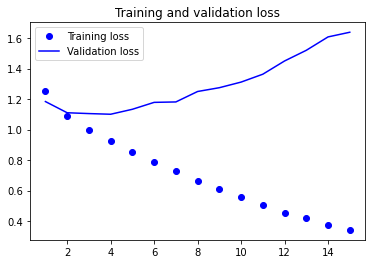

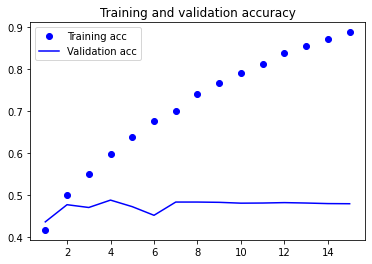

In [47]:
loss_conv1d = history_conv1d.history['loss']
val_loss_conv1d = history_conv1d.history['val_loss']
acc_conv1d = history_conv1d.history['accuracy']
val_acc_conv1d = history_conv1d.history['val_accuracy']


epochs_graph = range(1, len(acc_conv1d) + 1)

plt.plot(epochs_graph, loss_conv1d, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_conv1d, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_conv1d, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_conv1d, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

With a regular validation and wihtout any regularisation LSTM seems to have the best performance on the validation set. 
However, all of them are highly overfitting. 

As a next step, I am going to evaluate the models with cross-validation due to the low volume of data we have.

In [48]:
def with_cross_val(k, model, train_data, train_targets, epochs, batch_size):
    """
    This function applies a k-fold cross-validation.
    Args: 
        - k - number of folds
        - model - which model is to be used
        - train_data - the tokenised, padded and shuffled sequences
        - train_targets - labels 
        - epochs - number of epochs
        - batch_size - batch size

    Returns:
        - all_histories_acc - accuracy for all epochs and folds
        - all_histories_prec - precision for all epochs and folds
        - all_histories_rec - recall for all epochs and folds

    """
    num_val_samples = len(train_data) // k
    all_histories_acc = []
    all_histories_prec = []
    all_histories_rec = []

    for i in range(k):
        print('processing fold #', i)
        val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]
        val_targets = train_targets[i *
                                    num_val_samples:(i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_data[:i * num_val_samples],
             train_data[(i + 1) * num_val_samples:]],
            axis=0)

        partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples],
             train_targets[(i + 1) * num_val_samples:]],
            axis=0
        )

        #model = build_model()
        history = model.fit(
            partial_train_data, partial_train_targets,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            validation_data=(val_data, val_targets)
        )

        metric_history_acc = history.history['val_accuracy']
        all_histories_acc.append(metric_history_acc)

        metric_history_prec = history.history['val_precision']
        all_histories_prec.append(metric_history_prec)

        metric_history_rec = history.history['val_recall']
        all_histories_rec.append(metric_history_rec)

    return all_histories_acc, all_histories_prec, all_histories_rec

In [52]:
all_histories_acc_bow, all_histories_prec_bow, all_histories_rec_bow = with_cross_val(
    k=4,
    model=model_bow,
    train_data=data_oh,
    train_targets=labels_encoded_oh,
    epochs=epochs,
    batch_size=batch_size)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [53]:
average_acc_history_bow = [
    np.mean([x[i] for x in all_histories_acc_bow]) for i in range(epochs)]
average_acc_history_bow[-1]

0.299933597445488

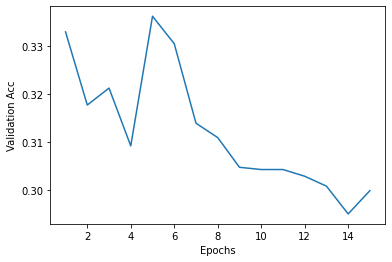

In [54]:
plt.plot(range(1, len(average_acc_history_bow) + 1), average_acc_history_bow)
plt.xlabel('Epochs')
plt.ylabel('Validation Acc')
plt.show()

In [55]:
all_histories_acc_emb, all_histories_prec_emb, all_histories_rec_emb = with_cross_val(
    k=4,
    model=model_emb,
    train_data=data_ovs,
    train_targets=labels_encoded,
    epochs=epochs,
    batch_size=batch_size)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [56]:
average_acc_history_emb = [
    np.mean([x[i] for x in all_histories_acc_emb]) for i in range(epochs)]
average_acc_history_emb[-1]

0.9130810052156448

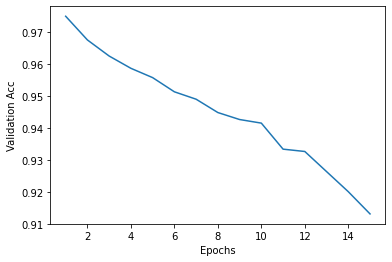

In [57]:
plt.plot(range(1, len(average_acc_history_emb) + 1), average_acc_history_emb)
plt.xlabel('Epochs')
plt.ylabel('Validation Acc')
plt.show()

In [58]:
all_histories_acc_transf, all_histories_prec_transf, all_histories_rec_transf = with_cross_val(
    k=4,
    model=model_transf,
    train_data=data_ovs,
    train_targets=labels_encoded,
    epochs=epochs,
    batch_size=batch_size)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [59]:
average_acc_history_transf = [
    np.mean([x[i] for x in all_histories_acc_transf]) for i in range(epochs)]
average_acc_history_transf[-1]

0.7801460772752762

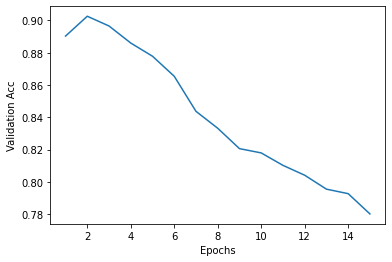

In [60]:
plt.plot(range(1, len(average_acc_history_transf) + 1),
         average_acc_history_transf)
plt.xlabel('Epochs')
plt.ylabel('Validation Acc')
plt.show()

In [61]:
all_histories_acc_lstm, all_histories_prec_lstm, all_histories_rec_lstm = with_cross_val(
    k=4,
    model=model_lstm,
    train_data=data_ovs,
    train_targets=labels_encoded,
    epochs=epochs,
    batch_size=batch_size)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [62]:
average_acc_history_lstm = [
    np.mean([x[i] for x in all_histories_acc_lstm]) for i in range(epochs)]
average_acc_history_lstm[-1]

0.674236387014389

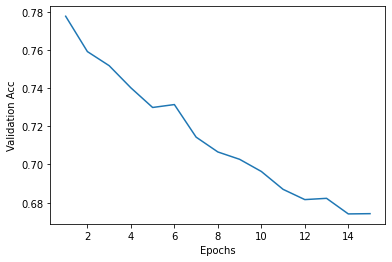

In [63]:
plt.plot(range(1, len(average_acc_history_lstm) + 1), average_acc_history_lstm)
plt.xlabel('Epochs')
plt.ylabel('Validation Acc')
plt.show()

In [64]:
all_histories_acc_conv1d, all_histories_prec_conv1d, all_histories_rec_conv1d = with_cross_val(
    k=4,
    model=model_conv1d,
    train_data=data_ovs,
    train_targets=labels_encoded,
    epochs=epochs,
    batch_size=batch_size)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [65]:
average_acc_history_conv1d = [
    np.mean([x[i] for x in all_histories_acc_conv1d]) for i in range(epochs)]
average_acc_history_conv1d[-1]

0.7667330652475357

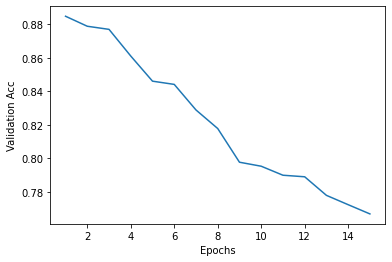

In [66]:
plt.plot(range(1, len(average_acc_history_conv1d) + 1),
         average_acc_history_conv1d)
plt.xlabel('Epochs')
plt.ylabel('Validation Acc')
plt.show()